In [1]:
import os, sys, time, pickle
from pathlib import Path
from collections import Counter

PROJECT_DIR = Path(sys.path[0])/".."
DATA_DIR = PROJECT_DIR/"data"
SRC_DIR = PROJECT_DIR/"src"
DEPS_DIR = PROJECT_DIR/"deps"

sys.path.append(str(SRC_DIR))
sys.path.append(str(DEPS_DIR))

%pylab inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload 
%autoreload 2

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from fairseq_wav2vec import Wav2Vec2Config, Wav2Vec2Model
import pandas as pd

from mugen_train import (
    musicDataset, IDX_to_GENRE, GENRE_TO_IDX, 
    get_music_data_loaders, GenreClassifier, get_batch_genre_one_hot,
    get_num_params)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# !jupyter nbextension enable --py widgetsnbextension


data

In [2]:
top50_genre_samples_df = pd.read_csv("/n1Tb/sc_mp3_top50_genre_samples.tsv_gz", compression='gzip', sep='\t')

train_loader, valid_loader = get_music_data_loaders(top50_genre_samples_df, cut=8e4)

model = Wav2Vec2Model(Wav2Vec2Config)
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.9,0.98), eps=1e-06, weight_decay=0.01, fused=True)

feature_size = 128
n_genres = 50

t_specs = {
#     "d_model": 128, 
    "dim_feedforward": 64, 
    "num_decoder_layers": 0,
    "num_encoder_layers": 0,
    "nhead": 1,
}
genre_classifier = GenreClassifier(n_genres, feature_size, t_specs=t_specs, use_transformer=False).to("cuda")
# genre_loss_model = GenreLoss(n_genres, feature_size, genre_classifier)

print(f"wav2vec-model n_params: {get_num_params(model):,d}")
print(f"genre_classifier n_params: {get_num_params(genre_classifier):,d}")

wav2vec-model n_params: 95,356,288
genre_classifier n_params: 6,450


In [3]:
data_loader = train_loader

model.train()
running_loss = 0.0
losses = []
for i, (batch, genres) in tqdm(enumerate(data_loader, 0), total=len(data_loader), disable=True):
    optimizer.zero_grad()
    outputs = model(batch)
    
    num_inf = torch.sum(torch.isinf(outputs["x"]))
    
    if num_inf:
        print(f"num_inf in output of model {num_inf}")
        break
        
    genre_props = genre_classifier(outputs["x"])
    min_max_prop = genre_props.min().to("cpu").item(), genre_props.max().to("cpu").item() 
    if np.isnan(min_max_prop[0]) or np.isnan(min_max_prop[1]):
        print("np.isnan(min_max_prop[0]) or np.isnan(min_max_prop[1])")
        break
    genre_loss = torch.nn.BCELoss()(genre_props, get_batch_genre_one_hot(genres, n_genres, "cuda"))

    wav2vec_features_pen = outputs["features_pen"]
    
    loss = genre_loss #+ 0.1 * wav2vec_features_pen
    loss_item = loss.to("cpu").item() 
    print("min_max_prop", min_max_prop)
    print("losses", loss_item, genre_loss.to("cpu").item(), wav2vec_features_pen.to("cpu").item())    

    loss.backward()
    optimizer.step()
    running_loss += loss_item
    losses.append(loss_item)

    out_is_inf = torch.isinf(outputs['x']).any().item()
    if out_is_inf:
        inf_values = torch.isinf(outputs['x']).sum() 
        print(f"{inf_values} inf values in output")
        break    

    for name, param in genre_classifier.named_parameters():
        has_nan = torch.isnan(param).any()
        has_inf = torch.isinf(param).any()

        if has_nan or has_inf:
            print(f"genre_classifier {name} has_nan {has_nan} has_inf {has_inf}.")
            break        
        
    for name, param in model.named_parameters():
        has_nan = torch.isnan(param).any()
        has_inf = torch.isinf(param).any()

        if has_nan or has_inf:
            print(f"Parameter {name} has_nan {has_nan} has_inf {has_inf}.")
            break

    if has_nan or has_inf:
        print("has_nan or has_inf")
        break
    
# return running_loss / len(data_loader)

min_max_prop (0.4520392417907715, 0.5303441882133484)
losses 0.6936724781990051 0.6936724781990051 0.20757219195365906
min_max_prop (0.46279412508010864, 0.53092360496521)
losses 0.6909421682357788 0.6909421682357788 18133940.0
min_max_prop (0.003154048230499029, 0.9981392621994019)
losses 1.0832147598266602 1.0832147598266602 1274364.25
min_max_prop (0.0009914473630487919, 0.9979864358901978)
losses 1.460135579109192 1.460135579109192 448180.6875
min_max_prop (0.18479204177856445, 0.7586262226104736)
losses 0.7335160374641418 0.7335160374641418 36.88273239135742
min_max_prop (9.873410454019904e-05, 0.9999595880508423)
losses 1.5500057935714722 1.5500057935714722 573716864.0
min_max_prop (0.00033484408049844205, 0.9998441934585571)
losses 1.3551312685012817 1.3551312685012817 2190111488.0
min_max_prop (0.012995255179703236, 0.9794410467147827)
losses 1.0988717079162598 1.0988717079162598 2588401664.0
min_max_prop (0.0003633878950495273, 0.9998294115066528)
losses 1.3832255601882935 1.3

In [48]:
torch.min(outputs["x"])

tensor(-inf, device='cuda:0', grad_fn=<MinBackward1>)

In [59]:
for name, param in model.named_parameters():
    print(param.shape)
#     has_nan = torch.isnan(param).any()
#     has_inf = torch.isinf(param).any()
#     print(torch.min(param), torch.max(param))
    if has_nan or has_inf:
        print(f"Parameter {name} has_nan {has_nan} has_inf {has_inf}.")
        break

torch.Size([768])

In [19]:
genre_props = genre_classifier(outputs["x"][:, 5:6, :])


min_max_prop = genre_props.min().to("cpu").item(), genre_props.max().to("cpu").item()
print(min_max_prop)

(nan, nan)


In [43]:
torch.min(outputs["x"][:, 5:6, :])

tensor(-inf, device='cuda:0', grad_fn=<MinBackward1>)

In [28]:
outputs["x"][:, 5, :].to("cpu")

ValueError: only one element tensors can be converted to Python scalars

In [41]:
torch.min(outputs["x"][:, 5, :]), torch.max(outputs["x"][:, 5, :])

(tensor(-inf, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(8.1407, device='cuda:0', grad_fn=<MaxBackward1>))

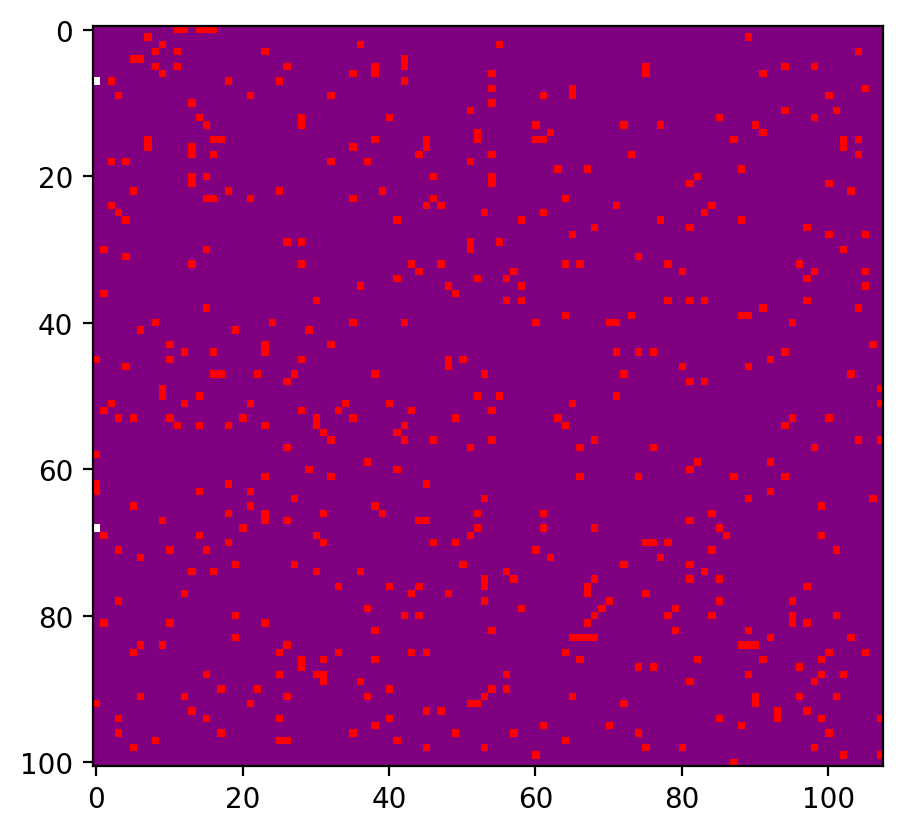

In [40]:
from matplotlib import colors
cmap = colors.ListedColormap(['red', 'blue', 'green', 'purple',])
bounds = [-2,0,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.imshow(outputs["x"][:, 5, :].to("cpu").detach().numpy(), cmap=cmap, norm=norm);


In [9]:
outputs["x"].shape

torch.Size([101, 12, 108])

In [13]:
outputs["x"][:, 5, :].view(-1)

tensor([[ 3.3394,  3.3260,  3.3887,  ...,  0.2598,  1.9368,  1.5712],
        [ 3.9297,  4.0692,  0.6154,  ...,  3.6812,  3.9889,  0.7476],
        [ 4.0207,  2.3219,  2.2242,  ...,  2.9346,  3.9889,  5.0196],
        ...,
        [ 3.5189,  3.3159,  0.6154,  ...,  3.3623,  2.1952,  4.0173],
        [ 2.2961,  2.1823,  3.7294,  ...,  2.3960,  5.0137, -0.0347],
        [ 3.5200,  3.3159,  5.5642,  ...,  3.9789,  3.9889,  4.0194]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [7]:
genre_props

tensor([[0.5695, 0.3973, 0.7511, 0.1627, 0.6493, 0.3275, 0.0887, 0.7731, 0.8138,
         0.5457, 0.0810, 0.5102, 0.7605, 0.8075, 0.7386, 0.0786, 0.8443, 0.5631,
         0.9625, 0.6363, 0.1389, 0.7848, 0.5494, 0.8912, 0.9155, 0.9652, 0.8007,
         0.6184, 0.6881, 0.5175, 0.7194, 0.7148, 0.8654, 0.9318, 0.4117, 0.7033,
         0.8355, 0.1206, 0.2134, 0.9707, 0.3930, 0.7667, 0.0458, 0.1134, 0.5651,
         0.2037, 0.4024, 0.5092, 0.7950, 0.0880],
        [0.5764, 0.3751, 0.7448, 0.1401, 0.6579, 0.3414, 0.0751, 0.7744, 0.8169,
         0.5502, 0.0834, 0.4983, 0.7798, 0.8178, 0.7527, 0.0738, 0.8536, 0.5810,
         0.9687, 0.6560, 0.1303, 0.7900, 0.5575, 0.8974, 0.9208, 0.9704, 0.8066,
         0.6329, 0.7021, 0.5072, 0.7239, 0.7074, 0.8692, 0.9336, 0.4017, 0.7012,
         0.8367, 0.1165, 0.1997, 0.9742, 0.3990, 0.7774, 0.0422, 0.1075, 0.5703,
         0.1799, 0.4140, 0.5024, 0.8082, 0.0783],
        [0.5572, 0.4109, 0.7146, 0.1811, 0.6319, 0.3603, 0.1140, 0.7418, 0.7929,
         

In [5]:
for name, param in genre_classifier.named_parameters():
    print(param)


Parameter containing:
tensor([[ 0.0410, -0.0627, -0.0819,  ..., -0.0716,  0.0092,  0.0186],
        [ 0.0190, -0.0306, -0.0257,  ..., -0.0130,  0.0600,  0.0464],
        [-0.0496, -0.0418,  0.0333,  ..., -0.0691, -0.0629,  0.0027],
        ...,
        [-0.0593,  0.0810,  0.0043,  ...,  0.0623,  0.0437,  0.0159],
        [-0.0800,  0.0101,  0.0367,  ...,  0.0093,  0.0865,  0.0833],
        [ 0.0506,  0.0068, -0.0344,  ..., -0.0049, -0.0750, -0.0531]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0666,  0.0769, -0.0589,  0.0088,  0.0770, -0.0631,  0.0296, -0.0852,
        -0.0138,  0.0382, -0.0125,  0.0260,  0.0037,  0.0587, -0.0495,  0.0227,
        -0.0517, -0.0357, -0.0754,  0.0814,  0.0666,  0.0005,  0.0072, -0.0829,
         0.0205,  0.0181, -0.0020, -0.0139,  0.0669, -0.0546,  0.0538,  0.0003,
         0.0427, -0.0369,  0.0525, -0.0223, -0.0311, -0.0612, -0.0653, -0.0865,
        -0.0715, -0.0029,  0.0690, -0.0655,  0.0234,  0.0476,  0.0725, -0.0571

In [17]:
param.size()

torch.Size([384])

In [ ]:
for name, param in genre_classifier.named_parameters():

In [7]:
genre_classifier.named_parameters()

GenreClassifier(
  (genre_transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_featur

In [ ]:
genre_props

In [5]:
outputs["x"]

tensor([[[-2.1734, -2.1676, -2.6694,  ..., -1.6409, -2.1309, -2.1816],
         [-2.1533, -2.3232, -2.0918,  ..., -2.9556, -2.3380, -2.1146],
         [-2.5770, -2.6286, -0.7590,  ..., -1.9916, -1.9645, -2.6201],
         ...,
         [-2.4726, -1.3606, -1.9379,  ..., -2.5782, -1.4332, -1.1699],
         [ 3.0867,  3.1184,  3.0901,  ...,  0.1815,  1.0042, -0.1994],
         [ 3.1160,  3.1264,  3.1052,  ...,  2.1382,  2.1611,  2.7250]],

        [[-1.9833, -1.8586,  2.5696,  ..., -2.3124, -2.1286, -2.6733],
         [-1.7463,  1.7897, -2.0662,  ..., -1.1333, -1.7055, -1.6615],
         [-1.9266, -2.9367, -0.9724,  ..., -2.1112, -2.5451, -1.5186],
         ...,
         [-2.1730, -1.3378, -2.7757,  ..., -2.1860, -2.6792, -2.5119],
         [-2.0726, -1.6207, -1.8092,  ..., -2.1611, -1.9689, -0.2427],
         [-2.6555, -2.0919,  2.6173,  ...,  0.3920, -1.8350, -2.0178]],

        [[-2.1359, -2.1553, -2.1664,  ..., -2.1740, -1.8800, -2.1877],
         [-0.7386, -2.2217, -2.5511,  ..., -1

In [13]:
np.isnan(min_max_prop[0])

True

In [4]:
print(loss_item, genre_loss.to("cpu").item(), wav2vec_features_pen.to("cpu").item())    



7.980274200439453 0.7756848335266113 0.22342604398727417


In [ ]:
genre_props

In [ ]:
genre_loss

In [ ]:
%debug


> /home/keld/miniconda3/envs/mugen_ml/lib/python3.9/site-packages/torch/autograd/__init__.py(197)backward()
    195     # some Python versions print out the first line of a multi-line function
    196     # calls in the traceback and some print out the last line
--> 197     Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    198         tensors, grad_tensors_, retain_graph, create_graph, inputs,
    199         allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass



ipdb>  up


> /home/keld/miniconda3/envs/mugen_ml/lib/python3.9/site-packages/torch/_tensor.py(488)backward()
    486                 inputs=inputs,
    487             )
--> 488         torch.autograd.backward(
    489             self, gradient, retain_graph, create_graph, inputs=inputs
    490         )



ipdb>  up


> /tmp/ipykernel_1546931/969730788.py(16)<module>()
     14 
     15     loss = 10*genre_loss + wav2vec_features_pen
---> 16     loss.backward()
     17     optimizer.step()
     18     loss_item = loss.to("cpu").item()



ipdb>  loss


*** RuntimeError: numel: integer multiplication overflow


ipdb>  up


*** Oldest frame


In [7]:
from ignite.handlers import FastaiLRFinder

trainer = ...
model = ...
optimizer = ...

lr_finder = FastaiLRFinder()
to_save = {"model": model, "optimizer": optimizer}

with lr_finder.attach(trainer, to_save=to_save) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(dataloader)

# Get lr_finder results
lr_finder.get_results()

# Plot lr_finder results (requires matplotlib)
lr_finder.plot()

# get lr_finder suggestion for lr
lr_finder.lr_suggestion()


TypeError: Object <class 'ellipsis'> should have `state_dict` method

### Test 2 -- with small update

In [4]:
train_loses = []
val_loses = []
for epoch in range(3):
    train_loss = train(model, optimizer, train_loader)
    val_loss = validation(model, valid_loader)
    print(f"{epoch:03d} train_loss: {train_loss:0.4f} val_loss: {val_loss:0.4f}")
    train_loses.append(train_loss)
    val_loses.append(val_loss)

100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.05it/s]


000 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.10it/s]


001 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.10it/s]

002 train_loss: 0.0000 val_loss: 0.0000


In [ ]:
plt.plot(train_loses, label="train_loses");
plt.plot(val_loses, label="val_loses");
plt.legend();

### Test 1 -- diverging

In [5]:
train_loses = []
val_loses = []
for epoch in range(5):
    train_loss = train(model, optimizer, train_loader)
    val_loss = validation(model, valid_loader)
    print(f"{epoch:03d} train_loss: {train_loss:0.4f} val_loss: {val_loss:0.4f}")
    train_loses.append(train_loss)
    val_loses.append(val_loss)

100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.10it/s]


000 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.11it/s]


001 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.11it/s]


002 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.09it/s]


003 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.05it/s]

004 train_loss: 0.0000 val_loss: 0.0000


In [ ]:
%debug

#### Scratchpad

In [49]:
for epoch in range(10):
    train_loss = train(model, optimizer, criterion, train_loader)
    print(f"Epoch {epoch+1}, train loss: {train_loss:.3f}")


In [66]:
for i, batch in enumerate(top50_dataloader):
    break

In [18]:
out = model.forward(sample_bs)

In [160]:
sample_bs.shape

torch.Size([32, 120000])

In [144]:

d.shape

torch.Size([2, 273024])

In [4]:
model.eval()
running_loss = 0.0
for i, (batch, genres) in tqdm(enumerate(valid_loader, 0), total=len(valid_loader)):
    outputs = model(batch)
    break

  0%|                                                                     | 0/17 [00:02<?, ?it/s]


In [18]:
outputs['x'].shape

torch.Size([101, 12, 120])

In [10]:
batch

<function __main__.music_collate_fn_wrap.<locals>.music_collate_fn(x)>